In [1]:
%matplotlib inline

In [2]:
import os
import json
import operator
from sodapy import Socrata # socrata api tools
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

# Data Gathering and Exploration
We will be using data from the Washington State open data portal, powered by Socrata. Specifically, we'll be taking a look at expenditures by candidates and political committees over the last 10 years. The dataset can be found online here:

https://data.wa.gov/Politics/Expenditures-by-Candidates-and-Political-Committee/tijg-9zyp

## Connect to the data source
Socrata provides several options for getting data. While we can download the data as a .csv file, I'm choosing to pull the data via their API. That way whenever I choose to re-run the notebook I can get the most up-to-date version of the data possible. Socrata provides excellent documentation for their API on all their datasets. The API reference for this dataset can be found here:

https://dev.socrata.com/foundry/data.wa.gov/ukxb-bc7h

In [4]:
portal_url = "data.wa.gov"
resource = "ukxb-bc7h"
refresh_data = True

In [5]:
# retrieve my app token
with open('secrets.json') as f:
    data = json.load(f)
    app_token = data['app_token']

In [6]:
# Establish connection to the client, retrieve one item for testing
client = Socrata(portal_url, app_token)
client.get(resource, limit=1)

[{'amount': '0.00',
  'election_year': '2016',
  'expenditure_date': '2016-10-18T00:00:00.000',
  'filer_id': 'VALDR  074',
  'filer_name': 'VALDERRAMA RAMIRO M',
  'first_name': 'RAMIRO',
  'id': '1102801.expn',
  'itemized_or_non_itemized': 'Non-itemized',
  'jurisdiction': 'LEG DISTRICT 45 - HOUSE',
  'jurisdiction_county': 'KING',
  'jurisdiction_type': 'Legislative',
  'last_name': 'VALDERRAMA',
  'legislative_district': '45',
  'middle_initial': 'M',
  'office': 'STATE REPRESENTATIVE',
  'origin': 'A/LE50',
  'party': 'REPUBLICAN',
  'position': '01',
  'recipient_name': 'EXPENSES OF $50 OR LESS',
  'report_number': '100733345',
  'type': 'Candidate',
  'url': 'http://web.pdc.wa.gov/rptimg/default.aspx?batchnumber=100733345',
  'url_description': 'View report'}]

### Success! 
Looks like we can connect to the API and pull data. There are about 700k rows in the dataset, so we will page through the results and store them in a list which we will concatenate at the end into a dataframe.

In [7]:
if (not os.path.isfile('spending_dollars.pkl')) or refresh_data:
    limit = 50000
    offset = 0
    frames = []
    while 1:
        result = client.get(resource, limit=limit, offset=offset)
        if len(result) == 0:
            break
        frames.append(pd.DataFrame.from_records(result))
        print(f"Page {int((offset/limit)+1)} loaded with {len(result)} rows")

        offset = offset + limit
    df = pd.concat(frames, ignore_index = True)
else:
    df = pd.read_pickle('spending_dollars.pkl')

Page 1 loaded with 50000 rows
Page 2 loaded with 50000 rows
Page 3 loaded with 50000 rows
Page 4 loaded with 50000 rows
Page 5 loaded with 50000 rows
Page 6 loaded with 50000 rows
Page 7 loaded with 50000 rows
Page 8 loaded with 50000 rows
Page 9 loaded with 50000 rows
Page 10 loaded with 50000 rows
Page 11 loaded with 50000 rows
Page 12 loaded with 50000 rows
Page 13 loaded with 50000 rows
Page 14 loaded with 48901 rows


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 32 columns):
amount                      698901 non-null object
ballot_number               33921 non-null object
code                        162748 non-null object
description                 598601 non-null object
election_year               698901 non-null object
expenditure_date            698634 non-null object
filer_id                    698901 non-null object
filer_name                  698901 non-null object
first_name                  387872 non-null object
for_or_against              57474 non-null object
id                          698901 non-null object
itemized_or_non_itemized    698901 non-null object
jurisdiction                403578 non-null object
jurisdiction_county         361056 non-null object
jurisdiction_type           387872 non-null object
last_name                   698901 non-null object
legislative_district        166904 non-null object
middle_initial          

### Data Cleaning
Looking at the info, there are a couple of columns that we would expect to be numeric. There are also a lot of NULL values for some of the string columns. Instead of leaving these as nan, we'll replace them with a string representation.

In [9]:
# string fill NaN first
df.fillna('NAN', inplace=True)

# then cast `amount` and `election_year` to numeric
df = df.astype({'amount': float, 'election_year': int})

# convert `expenditure_date` to datetime
df['expenditure_date'] = pd.to_datetime(df['expenditure_date'])

# save the output so we don't have to download each time
df.to_pickle('spending_dollars.pkl')

In [10]:
df.columns

Index(['amount', 'ballot_number', 'code', 'description', 'election_year',
       'expenditure_date', 'filer_id', 'filer_name', 'first_name',
       'for_or_against', 'id', 'itemized_or_non_itemized', 'jurisdiction',
       'jurisdiction_county', 'jurisdiction_type', 'last_name',
       'legislative_district', 'middle_initial', 'office', 'origin', 'party',
       'position', 'recipient_address', 'recipient_city', 'recipient_location',
       'recipient_name', 'recipient_state', 'recipient_zip', 'report_number',
       'type', 'url', 'url_description'],
      dtype='object')

## Data Exploration

In this next bit, we'll spend some time exploring the data.

What are the most recent records in the dataset? Is this dataset really up-to-date?

In [11]:
df.sort_values('expenditure_date', ascending=False).head(5).T

,402276,402280,402187,402205,402186
amount,50,50,586,429.8,197
ballot_number,NAN,NAN,NAN,NAN,NAN
code,NAN,NAN,Independent Expenditures,Independent Expenditures,Independent Expenditures
description,INTERNET ADD,INTERNET ADDS,SUNDAY 11/4 YAKIMA HERALD REPRINT AD,BLUE WAVE AD YAKIMA HERALD,EL SOL AD
election_year,2018,2018,2018,2018,2018
expenditure_date,2018-11-05 00:00:00,2018-11-02 00:00:00,2018-11-02 00:00:00,2018-11-02 00:00:00,2018-11-01 00:00:00
filer_id,IAFFLS 383,IAFFLS 383,HALLE 672,HALLE 672,HALLE 672
filer_name,IAFF L2819 FOR A SAFER KITSAP,IAFF L2819 FOR A SAFER KITSAP,HALLOCK ELIZABETH A,HALLOCK ELIZABETH A,HALLOCK ELIZABETH A
first_name,NAN,NAN,ELIZABETH,ELIZABETH,ELIZABETH
for_or_against,For,For,NAN,NAN,NAN


In [12]:
df['type'].unique()

array(['Candidate', 'Political Committee'], dtype=object)

In [13]:
df['office'].unique()

array(['CITY COUNCIL MEMBER', 'MAYOR', 'NAN', 'SCHOOL DIRECTOR',
       'PORT COMMISSIONER', 'STATE REPRESENTATIVE', 'STATE SENATOR',
       'GOVERNOR', 'SUPERINTENDENT OF PUBLIC INSTRUCTION',
       'COUNTY EXECUTIVE', 'COUNTY COUNCIL MEMBER', 'ATTORNEY GENERAL',
       'SUPERIOR COURT JUDGE', 'PUBLIC LANDS COMMISSIONER',
       'COUNTY ASSESSOR', 'FIRE COMMISSIONER', 'SECRETARY OF STATE',
       'COUNTY DIR OF ELECTIONS', 'COUNTY COMMISSIONER',
       'CITY COUNCIL PRESIDENT', 'COUNTY AUDITOR', 'COUNTY PROSECUTOR',
       'CIVIL SERVICE BOARD MEMBER', 'COUNTY SHERIFF', 'COUNTY TREASURER',
       'HOSPITAL COMMISSIONER', 'COUNTY CLERK',
       'PARK & RECREATION COMMISSIONER', 'INSURANCE COMMISSIONER',
       'DISTRICT COURT JUDGE', 'PUBLIC UTILITY COMMISSIONER',
       'CITY ATTORNEY', 'STATE SUPREME COURT JUSTICE', 'STATE TREASURER',
       'LIEUTENANT GOVERNOR', 'STATE AUDITOR', 'MUNICIPAL COURT JUDGE',
       'APPEALS COURT JUDGE', 'COUNTY DIR OF COMM DEV',
       'WATER COMMISSIO

In [14]:
df['code'].unique()

array(['NAN', 'Management Services', 'Wages and Salaries',
       'Operation and Overhead', 'Travel', 'Signature Gathering',
       'Postage', 'Broadcast Advertising', 'Contributions',
       'Independent Expenditures', 'Other Advertising', 'Fundraising',
       'Literature', 'Surveys and Polls', 'Printed Advertising'],
      dtype=object)

### General Spending
Let's take a cursory look at spending. We'll group by party and election year and view the sum. Sure are a lot of dollars in the "NAN" category...

In [15]:
# Spending by Party by Year
df.groupby(['party', 'election_year'])['amount'].sum().sort_values().unstack().T.sort_index()

party,CONSTITUTION PARTY,DEMOCRAT,INDEPENDENT,LIBERTARIAN,NAN,NON PARTISAN,NONE,OTHER,REPUBLICAN
election_year,,,,,,,,,
2008,NaN,13535960.66,39168.08,NaN,4.437094e+07,2780236.72,24625.94,94042.29,8523772.60
2009,NaN,426584.11,NaN,NaN,1.065851e+07,8654670.22,NaN,NaN,387308.34
2010,NaN,21707311.94,NaN,NaN,1.642654e+08,4616335.33,242638.21,216175.43,16594743.76
2011,NaN,891487.95,NaN,NaN,6.551765e+07,10576951.27,NaN,NaN,607361.05
2012,6381.03,35911222.42,66046.00,NaN,1.390803e+08,5355384.81,52892.20,273725.33,34763377.63
2013,NaN,1335087.38,5998.07,NaN,8.755170e+07,17451022.05,NaN,NaN,1839530.66
2014,NaN,13386136.70,96972.24,15663.16,6.725088e+07,2515179.23,133132.19,488142.29,12643582.99
2015,NaN,823046.82,NaN,NaN,2.611853e+07,7770179.42,NaN,NaN,847335.34
2016,NaN,22105241.76,5293.94,44340.21,7.556750e+07,3260013.41,139265.40,1634499.21,14229752.79


How about looking at the spending again, this time just for the Political Committees? Is there partisan spend for the PAC categories, or do those not have a political affiliation?

In [16]:
# Spending by Party by Year for Political Committees
df[df.type == 'Political Committee'].groupby(['party', 'election_year'])['amount'].sum().sort_values().unstack().T.sort_index()

party,NAN,NON PARTISAN,REPUBLICAN
election_year,,,
2008,4.437094e+07,NaN,NaN
2009,1.065851e+07,NaN,NaN
2010,1.642654e+08,NaN,NaN
2011,6.551765e+07,NaN,NaN
2012,1.390803e+08,NaN,NaN
2013,8.755149e+07,NaN,NaN
2014,6.725088e+07,NaN,NaN
2015,2.611853e+07,NaN,NaN
2016,7.556750e+07,NaN,NaN


This is a curiosity... there is a very small dollar amount for Republican political committee spending. What is it?

In [17]:
df[(df.type == 'Political Committee') & (df.party == 'REPUBLICAN')]

,amount,ballot_number,code,description,election_year,expenditure_date,filer_id,filer_name,first_name,for_or_against,...,recipient_address,recipient_city,recipient_location,recipient_name,recipient_state,recipient_zip,report_number,type,url,url_description
350822,67.47,NAN,NAN,ORDERED CHECKS,2018,2018-03-27,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,15955 LA CANTERA PARKWAY,SAN ANTONIO,"{'type': 'Point', 'coordinates': [-98.620006, ...",HARLAND CLARKE CHECK ORDER,TX,78256,100835820,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report
350966,0.00,NAN,NAN,NAN,2018,2018-03-01,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,NAN,NAN,NAN,EXPENSES OF $50 OR LESS,NAN,NAN,100835820,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report
361166,0.00,NAN,NAN,NAN,2018,2018-06-01,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,NAN,NAN,NAN,EXPENSES OF $50 OR LESS,NAN,NAN,100844391,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report
391519,0.00,NAN,NAN,NAN,2018,2018-07-31,28THDR 467,28TH DIST REPUB LEG COMM NON EXEMPT,NAN,NAN,...,NAN,NAN,NAN,EXPENSES OF $50 OR LESS,NAN,NAN,100855545,Political Committee,http://web.pdc.wa.gov/rptimg/default.aspx?batc...,View report


### For or Against?
I really dislike watching attack ads. What about this `for_or_against` column? Where makes up this info - from candidates or committees?

In [18]:
df.groupby(['type', 'for_or_against'])['amount'].count().unstack()

for_or_against,Against,For,NAN
type,,,
Candidate,NaN,NaN,387872.0
Political Committee,9945.0,47529.0,253555.0


What is the breakdown by spending code?

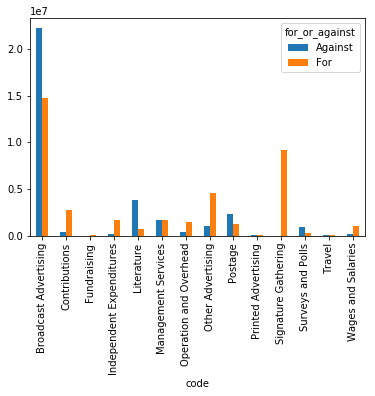

In [19]:
df[(df.type == 'Political Committee') & 
   (df.for_or_against != 'NAN') & 
   (df.code != 'NAN')
].groupby(['code', 'for_or_against'])['amount'].sum().unstack().plot(kind='bar')

What do the dollar amounts look like?

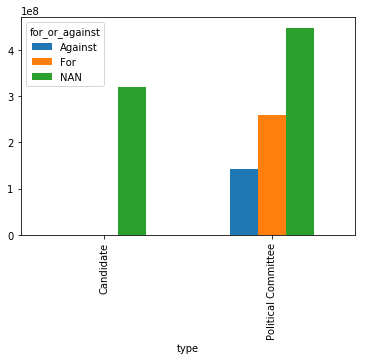

In [20]:
df.groupby(['type', 'for_or_against'])['amount'].sum().unstack().plot(kind='bar')

### Expenditure over time

What pattern does expenditure follow? Has it increased in recent years, or stayed the same?

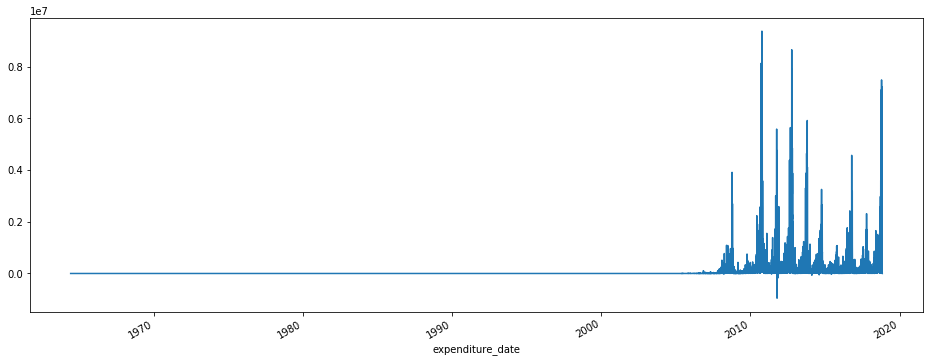

In [21]:
df.groupby('expenditure_date')['amount'].sum().plot(figsize=(16, 6))

#### 2018 election year

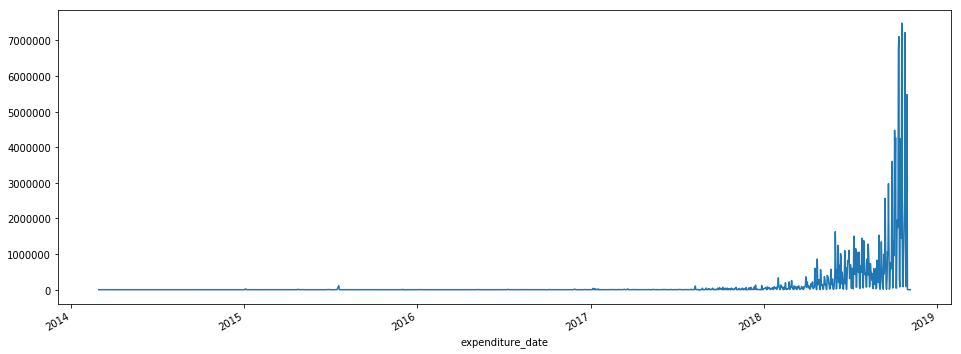

In [22]:
df[df.election_year == 2018].groupby('expenditure_date')['amount'].sum().plot(figsize=(16, 6))

In [23]:
df[df.election_year == 2018].sort_values('expenditure_date').head(5).T

,429004,244851,244125,244514,330236
amount,0,0,50,217.2,0
ballot_number,NAN,NAN,NAN,NAN,NAN
code,NAN,NAN,NAN,NAN,NAN
description,NAN,NAN,PAYMENT FOR SIGN STORAGE,PHONE LIST,NAN
election_year,2018,2018,2018,2018,2018
expenditure_date,2014-03-01 00:00:00,2014-03-01 00:00:00,2014-03-03 00:00:00,2014-03-12 00:00:00,2014-04-01 00:00:00
filer_id,LAKESC 258,VOICTE 038,VOICTE 038,VOICTE 038,CITIKS 626
filer_name,LAKE STEVENS CONCERNED CIT COMM,VOICE OF TAHOMA EDUCATION,VOICE OF TAHOMA EDUCATION,VOICE OF TAHOMA EDUCATION,CIT FOR KELSO SCHOOLS 2018 BALLOT
first_name,NAN,NAN,NAN,NAN,NAN
for_or_against,For,For,For,For,For


### Candidate Spending

Total amount of spend per candidate

In [24]:
df[df.type == 'Candidate'].groupby('filer_name')['amount'].sum().sort_values(ascending=False).head(10)

filer_name
INSLEE JAY R             21551748.41
MCKENNA ROBERT M         17662406.21
CONSTANTINE JAMES DOW     4031641.48
GREGOIRE CHRISTINE O      3270035.64
DUNN REAGAN B             3140669.67
BRYANT WILLIAM L          3120235.63
ROSSI DINO J              2944142.72
FERGUSON ROBERT W         2551977.90
MURRAY EDWARD B           2000774.33
LITZOW STEPHEN R          1909932.91
Name: amount, dtype: float64

Spend per candidate, by election year

In [25]:
df[df.type == 'Candidate'].groupby(['filer_name', 'election_year', 'office'])['amount'].sum().sort_values(ascending=False).head(20)

filer_name                 election_year  office          
MCKENNA ROBERT M           2012           GOVERNOR            16429638.60
INSLEE JAY R               2012           GOVERNOR            12569143.60
                           2016           GOVERNOR             8138859.84
ROSSI DINO J               2008           GOVERNOR             2944142.72
GREGOIRE CHRISTINE O       2008           GOVERNOR             2899922.43
BRYANT WILLIAM L           2016           GOVERNOR             2727155.50
DUNN REAGAN B              2012           ATTORNEY GENERAL     2263319.12
FERGUSON ROBERT W          2012           ATTORNEY GENERAL     1845877.46
CONSTANTINE JAMES DOW      2017           COUNTY EXECUTIVE     1627818.30
ENGLUND JINYOUNG           2017           STATE SENATOR        1625055.75
CONSTANTINE JAMES DOW      2013           COUNTY EXECUTIVE     1596772.14
DHINGRA MANKA              2017           STATE SENATOR        1526733.21
MURRAY EDWARD B            2013           MAYOR      

## Narrowing down the question

We've taken a look at the data in a number of different ways so far, and there are many other ways to slice and dice this data. We want to take the next step however, and see if there's something we can predict using the datset.

To me the spending by filer, election year, type and code is an interesting thing to look at. When we create this view, we have a single row for every candidate or political committee who filed an expenditure in a particular election year. What if we were to take the metadata out of this, and try and predict whether an entity is a political committee or a candidate based on their spend allocation during a particular election year?

In [26]:
data = df.groupby(['filer_name', 'election_year', 'type', 'code'])['amount'].sum().unstack('code').reset_index()
data.head()

code,filer_name,election_year,type,Broadcast Advertising,Contributions,Fundraising,Independent Expenditures,Literature,Management Services,NAN,Operation and Overhead,Other Advertising,Postage,Printed Advertising,Signature Gathering,Surveys and Polls,Travel,Wages and Salaries
0,$12 FOR TACOMA,2015,Political Committee,31074.0,NaN,NaN,NaN,NaN,NaN,55013.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10TH DIST DEMO NON EXEMPT,2008,Political Committee,NaN,NaN,NaN,NaN,NaN,NaN,19831.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10TH DIST DEMO NON EXEMPT,2009,Political Committee,NaN,NaN,NaN,NaN,NaN,NaN,1050.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10TH DIST DEMO NON EXEMPT,2010,Political Committee,NaN,NaN,NaN,NaN,NaN,NaN,8690.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10TH DIST DEMO NON EXEMPT,2011,Political Committee,NaN,NaN,NaN,280.0,NaN,NaN,2187.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define the Target
We will be using the `type` column as our target variable. We can transform it into a categorical variable that scikit-learn can handle.

In [27]:
target = data['type'].astype('category')
target.value_counts()

Political Committee    5595
Candidate              5393
Name: type, dtype: int64

### Define the Features
For the features we will use everything but the type, filer name, and the election year. We will also fill any NaN values with zeros.

In [28]:
features = data.drop(labels=['type', 'filer_name', 'election_year'], axis=1)
features = features.fillna(0)

### Set up the data and build a model
Let's split up the data by shuffling the dataframe and using 80% of the data to train our model.

In [29]:
# train/test split
train_test_args = dict(train_size = .8, test_size = .2, shuffle = True, random_state = 42)

features_train, features_test, target_train, target_test = train_test_split(features, target, **train_test_args)

Just to kick things off we will build a random forest classifier and train it on the data. This will be our baseline for now.

In [30]:
rf = RandomForestClassifier(n_estimators = 5000, n_jobs=-1, random_state=42)
rf.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [31]:
# results = pd.DataFrame({'predictions': rf.predict(features_test), 'actual': target_test})
# data.iloc[results[results['predictions'] != results['actual']].index].head()

In [32]:
rf.score(features_test, target_test)

0.694722474977252

### First Model Results
Looks like our first model gave us an average accuracy of around 69.5%. One idea is to not use the dollar amounts directly, but the percentage of spend inside each of the categories. We can create that dataset and fit another model.

In [33]:
featuresPCT = features.divide(features.sum(axis=1), axis='rows').fillna(0)

In [34]:
features_train, features_test, target_train, target_test = train_test_split(featuresPCT, target, **train_test_args)
rf_pct = RandomForestClassifier(n_estimators = 5000, n_jobs=-1, random_state=42)
rf_pct.fit(features_train, target_train)
rf_pct.score(features_test, target_test)

0.7001819836214741

Let's try a few different classifiers!

In [35]:
classifiers = {
    #'RandomForest': RandomForestClassifier(n_estimators = 5000, n_jobs=-1),
    'LogisticRegression': LogisticRegressionCV(cv=10, max_iter=1000, solver='liblinear'),
    'AdaBoostClassifier': AdaBoostClassifier(n_estimators=2000, learning_rate=.25),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=2000)
}

In [36]:
perf = {}
for name, model in classifiers.items():
    model.fit(features_train, target_train)
    score = model.score(features_test, target_test)
    print(f'{name}: {score:.4%}')
    perf[name] = score

LogisticRegression: 62.3749%
AdaBoostClassifier: 71.1556%
GradientBoostingClassifier: 70.4732%


In [37]:
best_model_name = max(perf.items(), key=operator.itemgetter(1))[0]
print(f"The Best Model is ... {best_model_name}")

best = classifiers[best_model_name]

The Best Model is ... AdaBoostClassifier


In [38]:
target_test.value_counts()

Political Committee    1112
Candidate              1086
Name: type, dtype: int64

In [39]:
target_test[target_test == best.predict(features_test)].value_counts()

Political Committee    797
Candidate              767
Name: type, dtype: int64

In [40]:
tn, fp, fn, tp = confusion_matrix(target_test, best.predict(features_test)).ravel()
print(f"""Confusion Matrix:
True PAC: {tp}
True Candidate: {tn}
False PAC: {fp}
False Candidate: {fn}""")

Confusion Matrix:
True PAC: 797
True Candidate: 767
False PAC: 319
False Candidate: 315


In [41]:
joblib.dump(best, 'bestModel.joblib')

['bestModel.joblib']